# Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline

# Pour avoir des graphes jolis et tenant à l'écran
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 20, 8

# Pour reproduire les resultats
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# 1- Explorons la donnée

- regarder et afficher le contenu du fichier de donnée spx.csv

In [2]:
data = "spx.csv"

In [3]:
df = #TODO

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


,close
count,8192.000000
mean,1070.897411
std,616.714534
min,203.490000
25%,458.632500
50%,1106.435000
75%,1388.132500
max,2872.870000


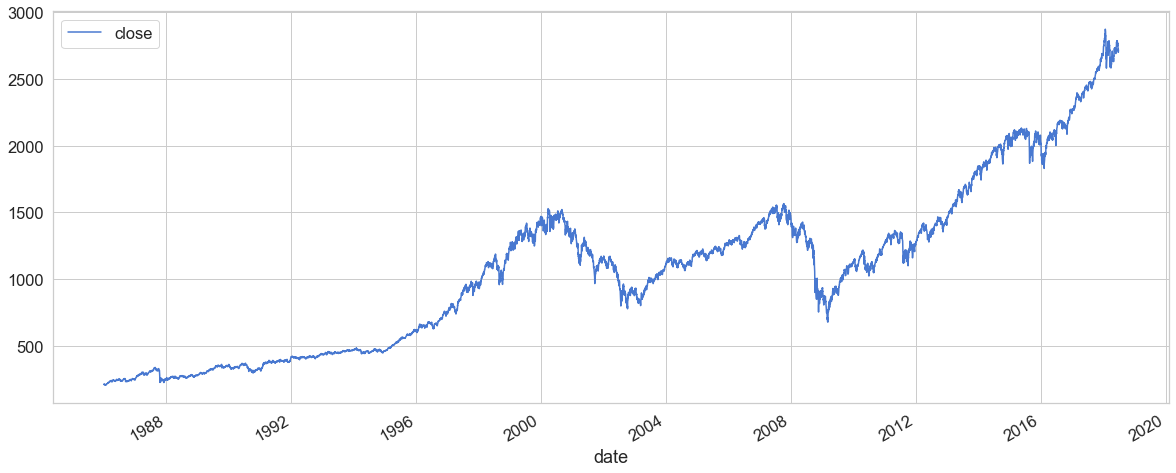

# 2- Création et mise en forme des jeux de données d'entrainement et de validation

### Notre objectif dans ce TP va être d'apprendre à détecter des anomalies dans cette courbe
- Pour cela, nous allons entrainer un lstm-autoencoder à apprendre à reconstruire la courbe
- Puis nous allons lui demander de reconstruire un episode non vu dans l'entrainement. Si sa reconstruction est très différente de l'entrée, c'est une anomalie

- Nous allons vouloir entrainer notre modele sur la majorité de notre série temporelle, puis évaluer ses performances sur le reste de celle-ci. Séparons (arbitrairement) 95% des points dans le train, et les 5% restants dans le tests.

In [7]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
# Astuce : vous pouvez utiliser iloc pour obtenir directement le format habituel de ML 
# (nb_echantillon, nb_feature_par_echantillon), puis .values pour obtenir une liste plutot qu'un dataframe 
train_data = # TODO
test_data = # TODO

assert (train_data.shape == (7782, 1))
assert (test_data.shape == (410, 1))

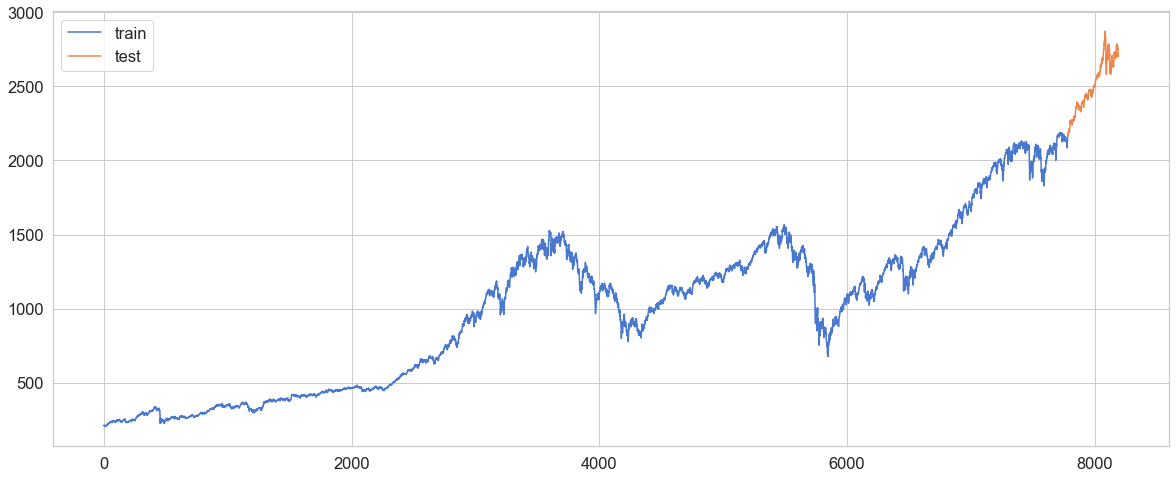

In [10]:
plt.plot(train_data, label = "train")
plt.plot(range(len(train_data), len(train_data)+len(test_data)),test_data, label="test")
plt.legend()

- Les réseaux de neurones n'aime pas les valeurs très grandes en entrée. Standardisons donc notre serie temporelle de train et de validation pour ramener ses valeurs proches de 0
    - Attention, comme toute méthode de préprocessing qui doit être d'abord fittée sur les données, il faut JAMAIS fit sur le jeu d'evaluation
    - sinon les performances de l'evaluation serons faussées, car le jeu d'eval aura été utilisée pour l'entrainement d'une des méthodes utilisées

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = # TODO

train_data = #TODO
test_data = # TODO

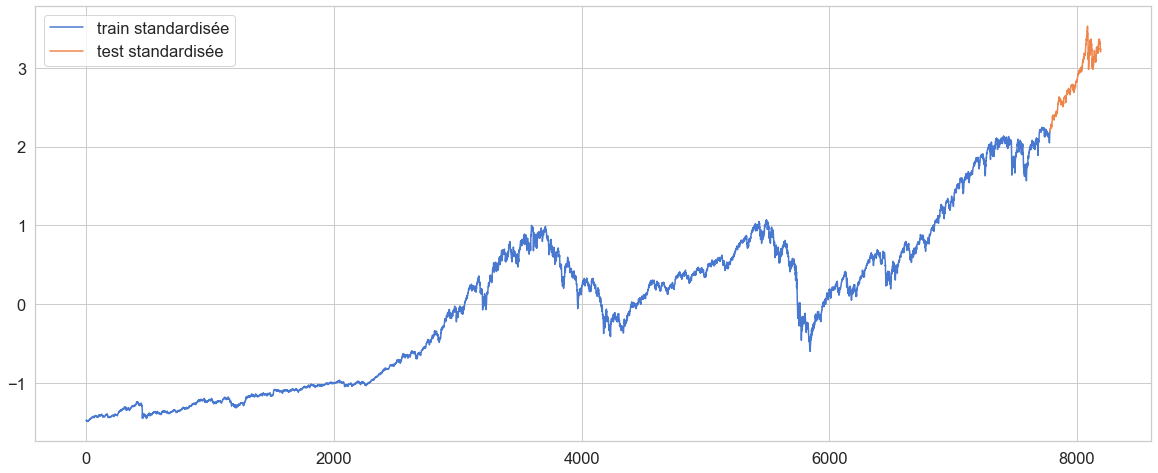

In [15]:
plt.plot(train_data, label = "train standardisée")
plt.plot(range(len(train_data), len(train_data)+len(test_data)),test_data, label="test standardisée")
plt.legend()

- Il faut maintenant structurer les données pour entrainer notre modèle.
- Nous devons donc lui faire apprendre à reconstruire la même série temporelle qu'en entrée sur une fenetre de temps
    - il nous faut donc découper le jeu d'entrainement en sequences de taile_de_la_fenetre éléments consécutifs

In [16]:
WINDOW_LEN = 30

x_list = list()

# TODO

x_train = np.array(x_list)
assert(x_train.shape == (7752, 30, 1))

- faisons la même chose pour le test

In [18]:
x_list = list()
for i in range(len(test_data) - WINDOW_LEN):
    x_list.append(test_data[i: i + WINDOW_LEN])
x_test = np.array(x_list)

- verifions que vous avez bien la même taille que moi

In [20]:
assert(x_train.shape == (7752, WINDOW_LEN, 1))
assert(x_test.shape == (380,WINDOW_LEN, 1))

# 3- Creation du modele

- Créer un modele n'est pas facile !
- Regardons une architecture typique de lstm-encoder, que vous pouvez reproduire à l'identique ou vous en inspirer
- Source de l'image : https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

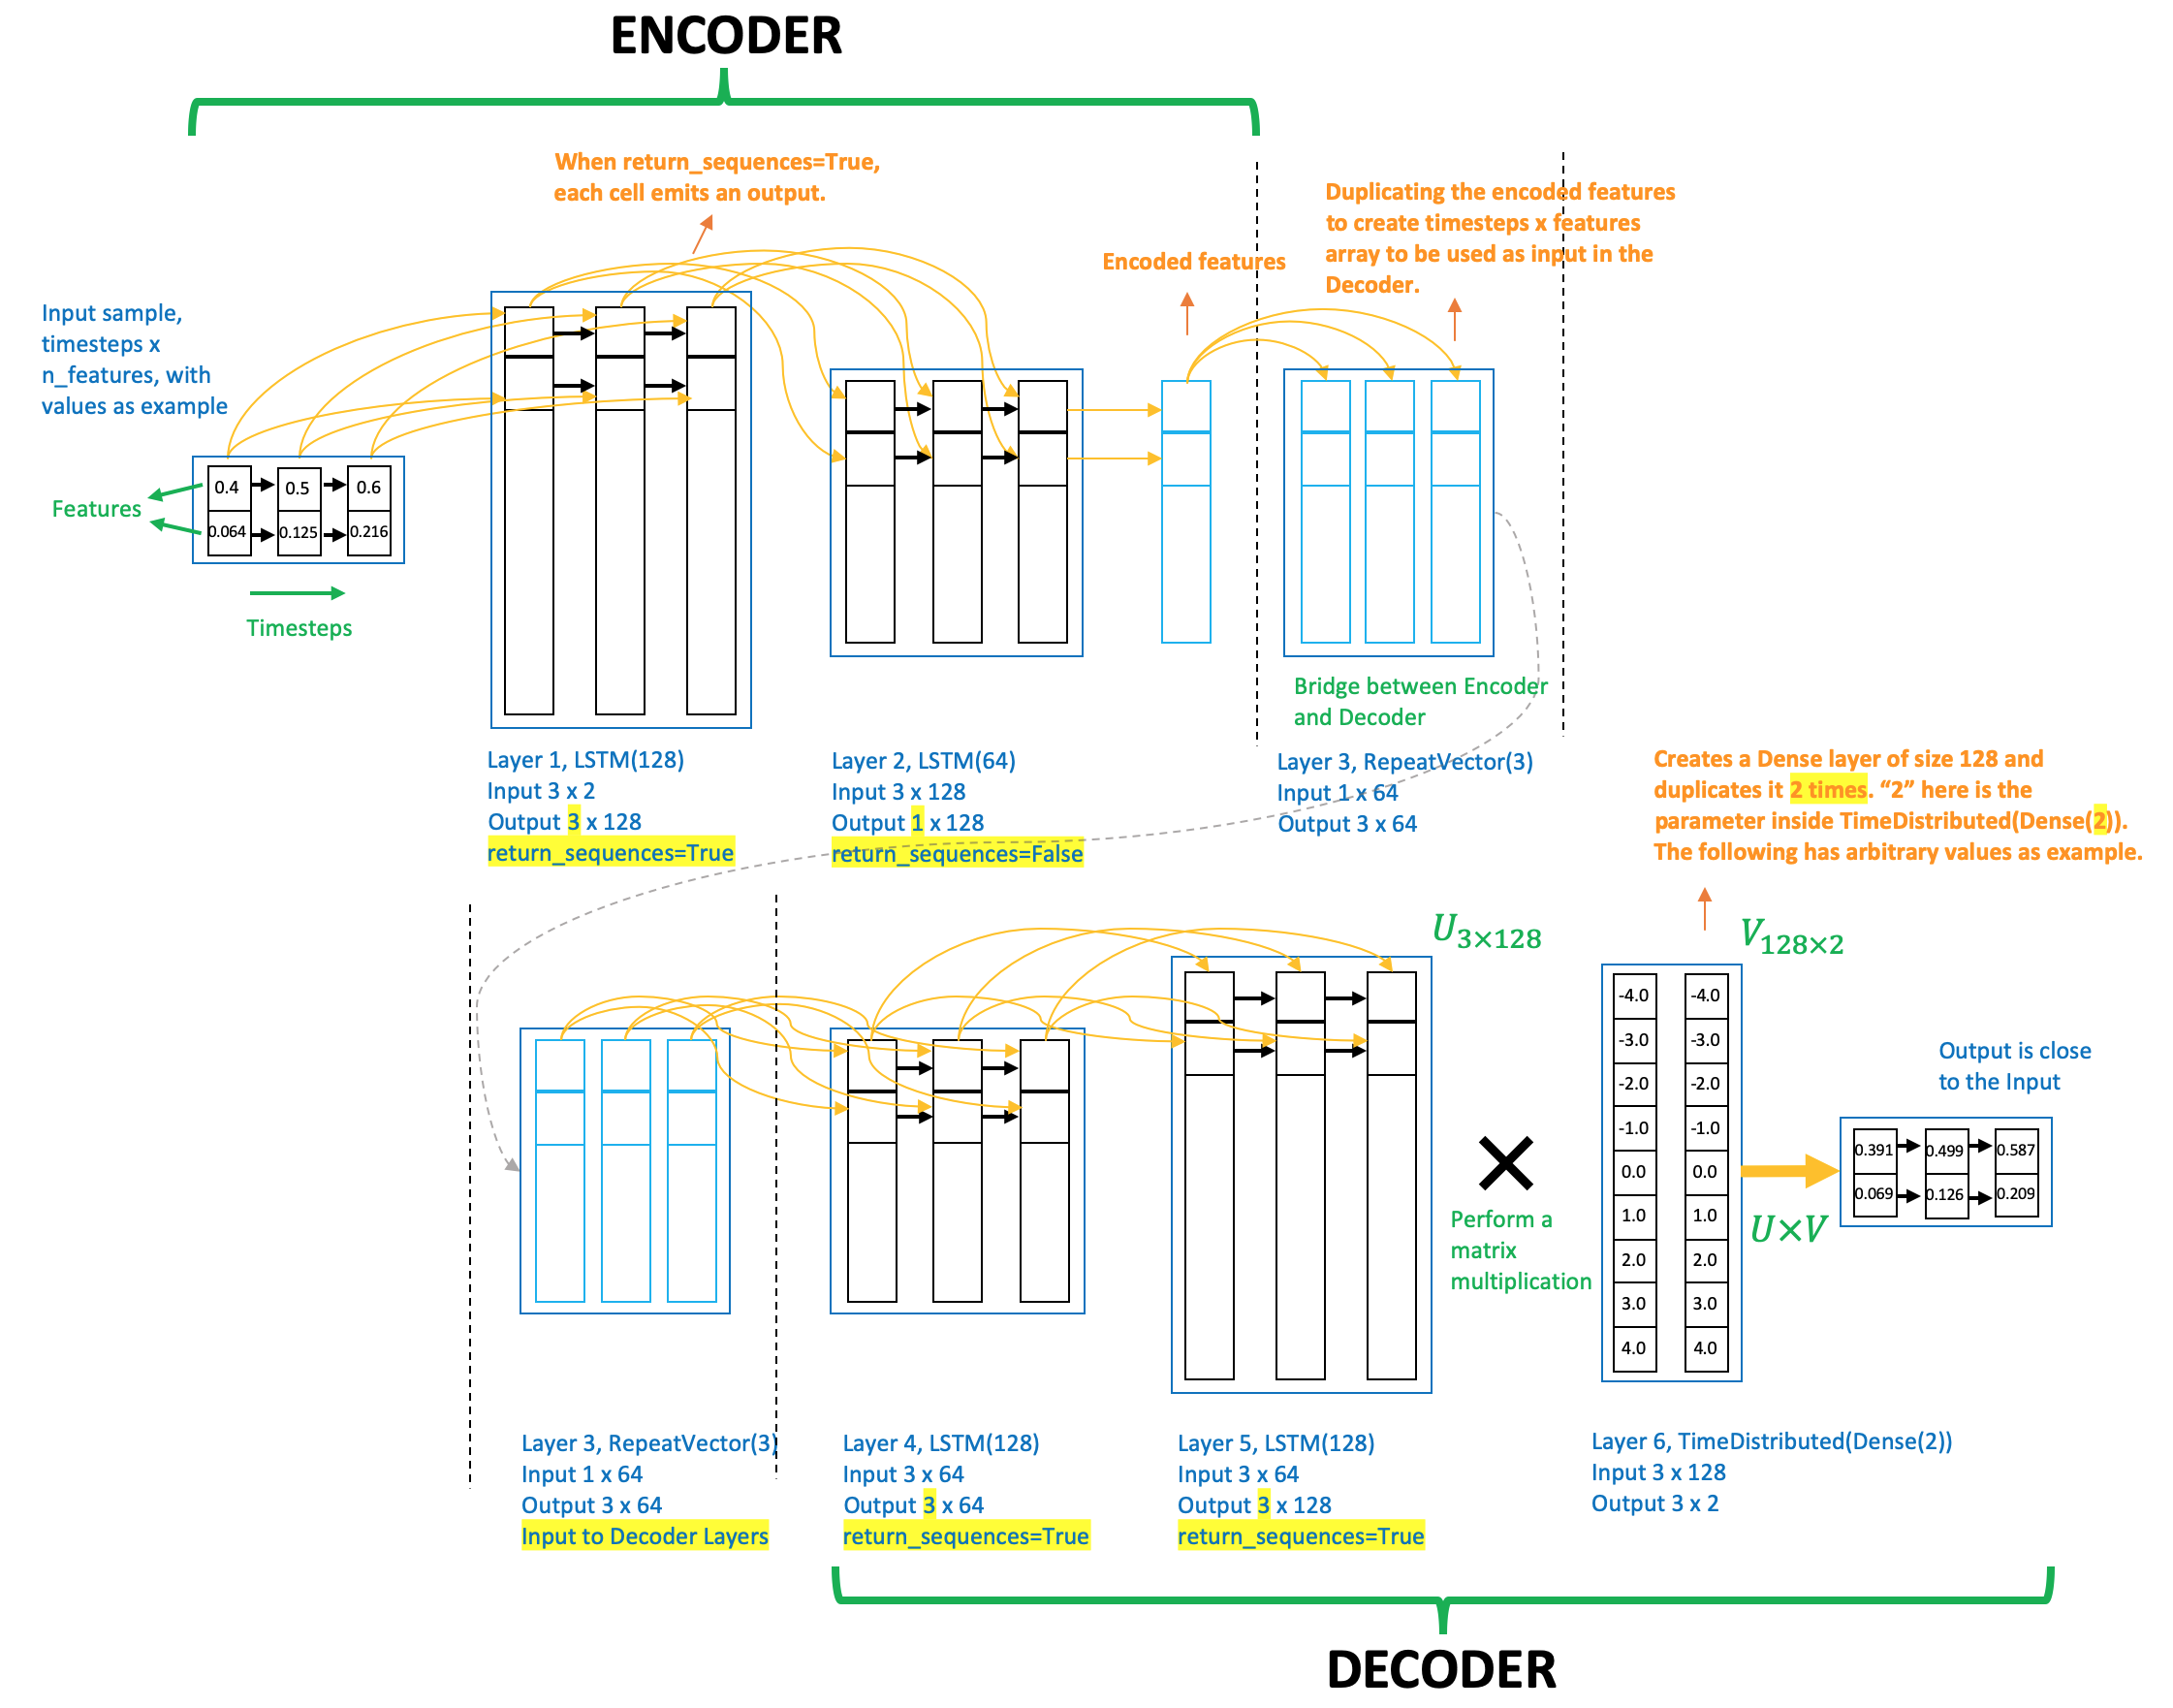

In [21]:
from IPython.display import Image
Image(filename='1_sWc8g2yiQrOzntbVeGzbEQ.png') 

- implémentons puis entrainons notre lstm encoder-decoder

In [22]:
model = keras.Sequential()
# TODO

model.compile(loss='mae', optimizer='adam')

In [39]:
history = model.fit(
    x_train, x_train,
    epochs=12,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/12
218/218 [==============================] - 3s 12ms/step - loss: 0.1275 - val_loss: 0.2265
Epoch 2/12
218/218 [==============================] - 3s 13ms/step - loss: 0.1283 - val_loss: 0.2215
Epoch 3/12
218/218 [==============================] - 3s 12ms/step - loss: 0.1250 - val_loss: 0.3066
Epoch 4/12
218/218 [==============================] - 3s 12ms/step - loss: 0.1354 - val_loss: 0.2831
Epoch 5/12
218/218 [==============================] - 3s 13ms/step - loss: 0.1257 - val_loss: 0.3251
Epoch 6/12
218/218 [==============================] - 3s 13ms/step - loss: 0.1230 - val_loss: 0.2990
Epoch 7/12
218/218 [==============================] - 3s 13ms/step - loss: 0.1248 - val_loss: 0.3550
Epoch 8/12
218/218 [==============================] - 3s 13ms/step - loss: 0.1175 - val_loss: 0.4039
Epoch 9/12
218/218 [==============================] - 3s 13ms/step - loss: 0.1168 - val_loss: 0.3502
Epoch 10/12
218/218 [==============================] - 3s 13ms/step - loss: 0.1294 - val_lo

- regardons si notre modele fait de l'overfitting en comparant loss d'entrainement et de validation

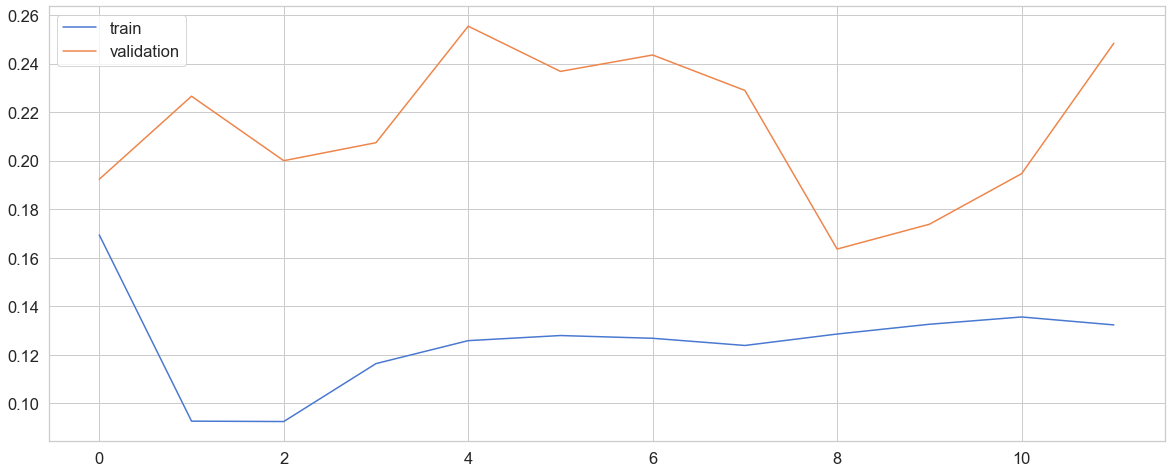

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

# 4- Exploitons notre autoencoder pour détecter les anomalies 

In [28]:
train_preds = model.predict(x_train)
test_preds = model.predict(x_test)

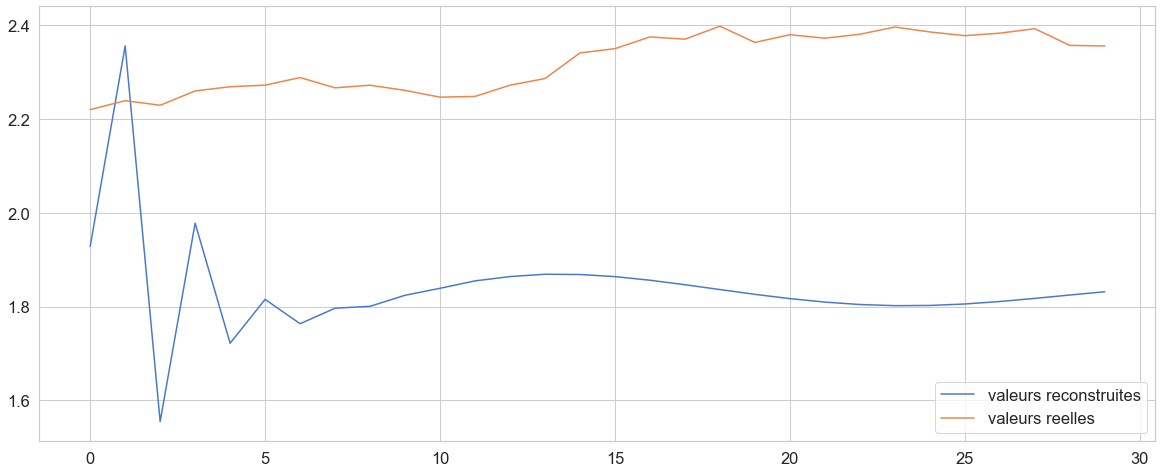

In [29]:
num_sample = 3
plt.plot(test_preds[num_sample], label='valeurs reconstruites')
plt.plot(x_test[num_sample], label = 'valeurs reelles')
plt.legend()

- pour faire simple, nous pouvons regarder l'erreur moyenne de recontruction.
- si celle-ci est élevée, c'est que la série temporelle sur les 30 points actuels ne suit plus la même logique que celles vues lors de l'entrainement
    - c'est donc qu'il y a une anomalie sur ces 30pts
- pour faire un petit peu mieux, nous pouvons regarder uniquement l'erreur moyenne sur les points reconstruis 5 et plus, comme nous constatons qu'au depart de la séquence, l'ecart entre les courbes précédente est plus élevée

- Il nous faut maintenant décider du seuil d'anomalie, i.e à partir de quand disons nous que l'erreur de reconstruction est trop importante, et il s'agit d'une anomalie

C:\Users\maxime.carrere\Documents\ynov\2022\dl\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


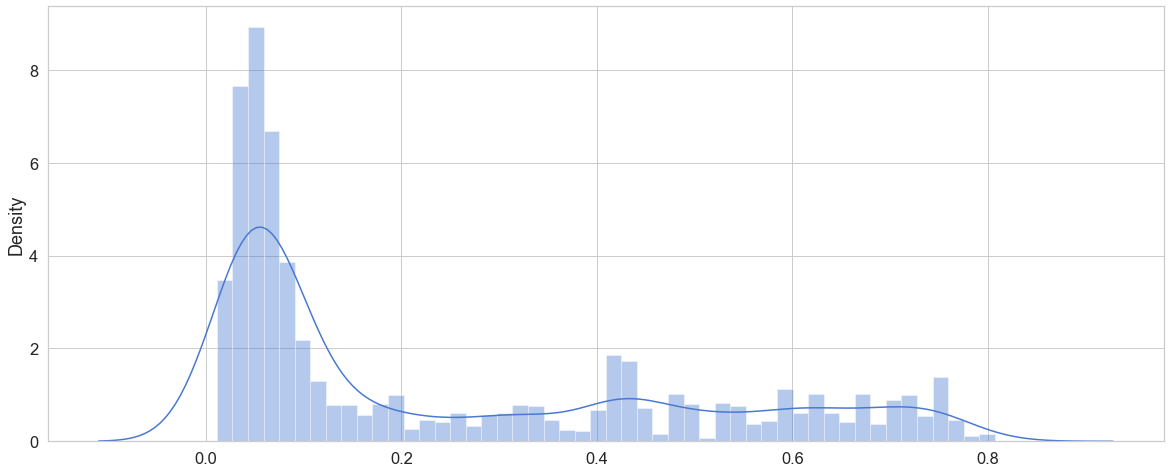

In [30]:
train_mae_loss = np.mean(np.abs(train_preds - x_train), axis=1)
sns.distplot(train_mae_loss, bins=50, kde=True);

- Nous pouvons prendre ici un seuil à 0.8 si nous sommes sure qu'il n'y avait aucune anomalie dans notre jeu d'entrainement
- Si nous pensons qu'il y a quelques anomalies dans notre jeu d'entrainement, il faut le mettre plus bas
- Dans un vrai projet, nous essayerons de déterminer avec un expert métier le taux d'anomalie dans le jeu d'entrainement, et fixer le seuil en fonction

In [33]:
THRESHOLD = 0.55

C:\Users\maxime.carrere\Documents\ynov\2022\dl\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


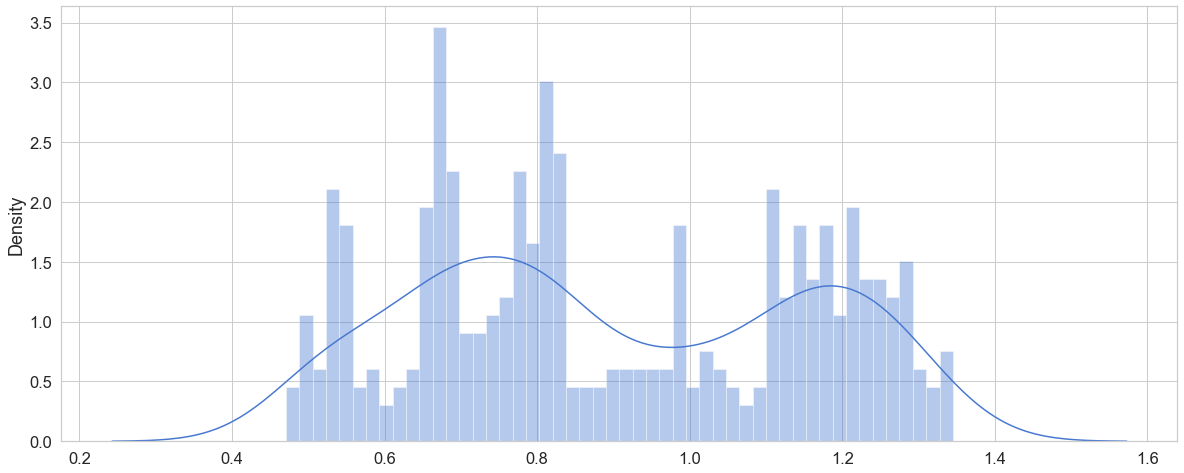

In [34]:
test_mae_loss = np.mean(np.abs(test_preds - x_test), axis=1)
sns.distplot(test_mae_loss, bins=50, kde=True);

- Nous avons un groupe d'erreur de reconstruction dans la partie droite qui semble très important par rapport aux erreurs de l'entrainement
- Regardons ça :

In [35]:
test_score_df = pd.DataFrame(index=df[train_size+WINDOW_LEN:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = df[train_size+WINDOW_LEN:].close

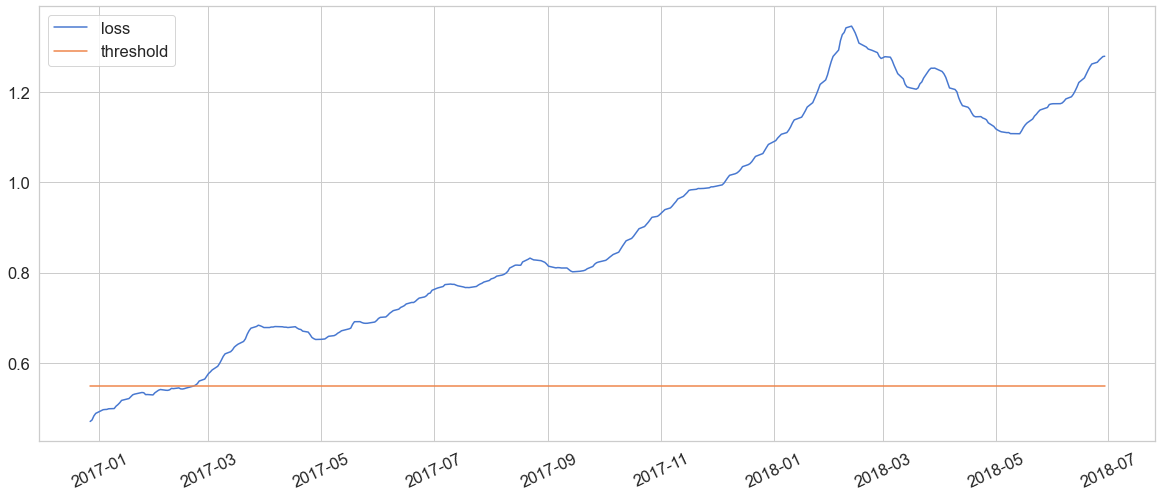

In [36]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

- effectivement, nous avons un endroit pour lequel notre modèle semble avoir détecter une anomalie
- la loss augmente au cours du temps, signe que 
    - nous n'avons pas eu assez de data pour estimer la tendance
    - la standardisation a pu nous empecher de saisir celle-ci

In [37]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2017-02-22,0.551165,0.55,True,2362.82
2017-02-23,0.554456,0.55,True,2363.81
2017-02-24,0.560251,0.55,True,2367.34
2017-02-27,0.564607,0.55,True,2369.75
2017-02-28,0.570776,0.55,True,2363.64


C:\Users\maxime.carrere\Documents\ynov\2022\dl\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


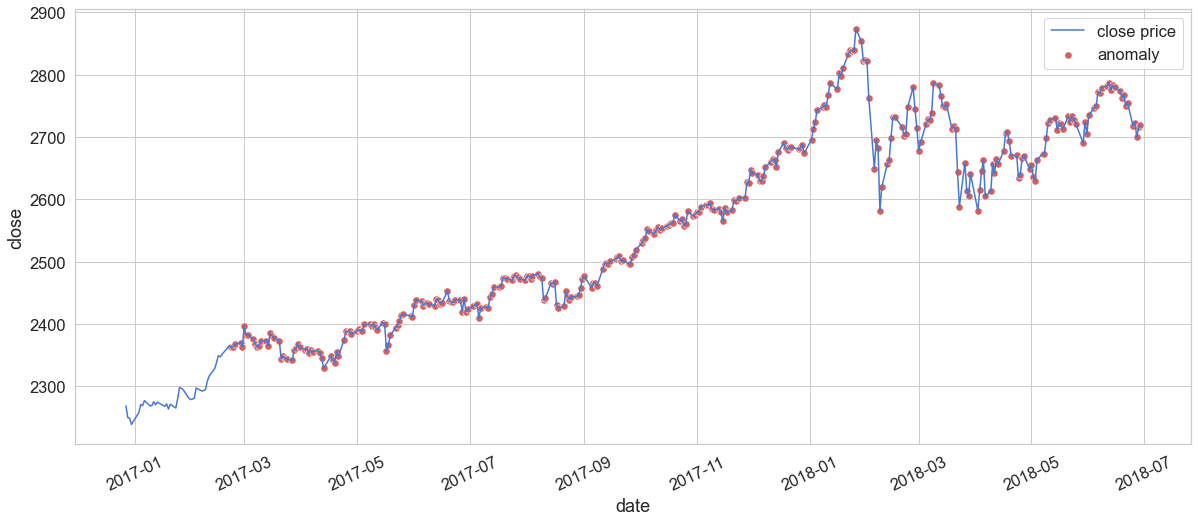

In [38]:
plt.plot(
  df[train_size+WINDOW_LEN:].index, 
  df[train_size+WINDOW_LEN:], 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  anomalies["close"],
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

# Pour aller plus loin

- entrainer un meilleur réseau
- changer la taille des séquences utilisées
- retirez la tendance des données (ou de la loss :p)
- élaborer une méthode de détection d'anomalie à partir de la reconstruction plus précise (fenetre pour la moyenne mieux choisie, seuil evolutif, ...)
- comment appliquer la même méthode pour détecter les anomalies non seulement en fonction de l'evolution de cette courbe, mais aussi d'autres index boursiers ?